**Conversion of float32 CNN model to int8 CNN model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow_model_optimization as tfmot
import h5py
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
import tempfile
import zipfile
import os
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('training_and_test_data.csv')

In [ ]:
data.shape

(3387307, 129)

In [ ]:
float_col = data.select_dtypes(include=['float64'])
for col in float_col.columns.values:
     data[col] = data[col].astype('float32')

max_value = data.max().max()
max_value

data = np.array(data)
m, n = data.shape
np.random.shuffle(data)


data_test = data[0:1000000].T
Y_test = data_test[0].T
X_test = data_test[1:n].T
X_test = X_test / max_value

data_train = data[1000000:m].T
Y_train = data_train[0].T
X_train = data_train[1:n].T
X_train = X_train / max_value


In [ ]:
X_train.shape

(2387307, 128)

In [ ]:
X_test.shape

(1000000, 128)

In [ ]:
X_train = X_train.reshape(2387307, 16,8)
X_test = X_test.reshape(1000000, 16,8)

In [ ]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(16, 8)),
    keras.layers.Reshape(target_shape=(16, 8, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu,  use_bias=True , kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'softmax', use_bias=True)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

reg_history = model.fit(X_train, Y_train, 
                            validation_data=(X_test, Y_test), 
                            epochs=10, 
                            callbacks=EarlyStopping(monitor='val_loss'))

Epoch 1/10
74604/74604 [==============================] - 460s 6ms/step - loss: 0.1581 - accuracy: 0.9947 - val_loss: 0.0531 - val_accuracy: 0.9990
Epoch 2/10
74604/74604 [==============================] - 444s 6ms/step - loss: 0.0394 - accuracy: 0.9992 - val_loss: 0.0309 - val_accuracy: 0.9993


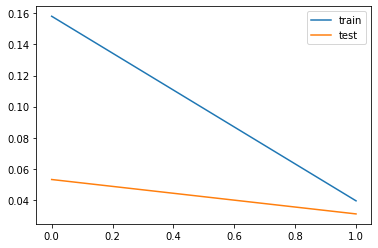

In [ ]:
plt.plot(reg_history.history['loss'], label='train')
plt.plot(reg_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, Y_test)

31250/31250 [==============================] - 95s 3ms/step - loss: 0.0309 - accuracy: 0.9993


[0.030942535027861595, 0.9993069767951965]

In [ ]:
model.save('conv_model_earlystop_l2_reg.h5')
model.save("./conv_model_earlystop_l2_reg/")

INFO:tensorflow:Assets written to: ./conv_model_earlystop_l2_reg/assets


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 8, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 14, 6, 12)         120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 3, 12)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 252)               0         
                                                                 
 dense (Dense)               (None, 256)               64768     
                                                                 
Total params: 64,888
Trainable params: 64,888
Non-trainable params: 0
____________________________________________________

**Converting float32 model into int8 model. Here, input will be int8 and output is uint8**

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp0tl4ib0w/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/drive/MyDrive")
tflite_models_dir.mkdir(exist_ok=True, parents=True)


tflite_model_quant_file = tflite_models_dir/"conv_int8_model_earlystop_l2_reg.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

69696

**Quantized model check with test data**

In [ ]:

def run_tflite_model(tflite_file, test_indices):
  global test_datas


  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_indices),), dtype=int)
  for i, test_index in enumerate(test_indices):
    test_input = X_test[test_index]
    test_label = Y_test[test_index]

    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      test_input = test_input / input_scale + input_zero_point

    test_input = np.expand_dims(test_input, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_input)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:

def evaluate_model(tflite_file, model_type):
  global test_datas
  global test_labels

  test_indices = range(X_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_indices)

  accuracy = (np.sum(Y_test== predictions) * 100) / len(Y_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(X_test)))
  print('match', np.count_nonzero(predictions==Y_test))
  print('mismatch', (len(X_test) - (np.count_nonzero(predictions==Y_test))))


**Accuracy of float32 model and int8 model is same**

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 99.9173% (Number of test samples=1000000)
match 999173
mismatch 827
